# Imports

In [2]:
# Import pandas
import pandas as pd

# Import matplotlib
import matplotlib.pyplot as plt

# Import Network X
import networkx as nx

# Read names_df

In [4]:
# Set path
names_path = '../src/visualization/mesh.pkl'

# Read
names_df = pd.read_pickle(names_path)

# Echo
names_df.head()

,category,mesh_heading,mesh_id,mesh_treenumbers
0,D,Calcimycin,D000001,D03.633.100.221.173
1,D,Temefos,D000002,D02.705.400.625.800
2,J,Abattoirs,D000003,J01.576.423.200.700.100
3,L,Abbreviations as Topic,D000004,L01.559.598.400.556.131
4,A,Abdomen,D000005,A01.923.047


# Construct Gephi labels

In [6]:
# Check all entries
print('Shape -Before-: ', names_df.shape)

# Check non-None entries
gephi_labels = names_df.dropna(axis=0)

# Check for duplicates
gephi_labels = gephi_labels.drop_duplicates(subset='mesh_id', keep='first')

# Check all entries - again
print('Shape  -After-: ', gephi_labels.shape)

# Copy only id and label
gephi_labels = gephi_labels.drop(columns='mesh_treenumbers category'.split())

# Rename for csv-file
gephi_labels = gephi_labels.rename(columns={'mesh_id':'id', 'mesh_heading':'label'})

# Save to .csv
gephi_labels['id label'.split()].to_csv('titles.csv', index=False)

# Echo
gephi_labels.head()

Shape -Before-:  (59748, 4)
Shape  -After-:  (29349, 4)


,label,id
0,Calcimycin,D000001
1,Temefos,D000002
2,Abattoirs,D000003
3,Abbreviations as Topic,D000004
4,Abdomen,D000005


# Read tags_df

In [8]:
# Set path
tags_path = '../src/visualization/geo.pkl'

# Read
tags_df = pd.read_pickle(tags_path)

# Echo
tags_df.head()

,geo_id,nsamples,date,mesh_id,mesh_heading,category,method
0,200000001,38,2001/01/22,D011379,Prognosis,E,pmid
1,200000001,38,2001/01/22,D016000,Cluster Analysis,E,pmid
2,200000001,38,2001/01/22,D016000,Cluster Analysis,N,pmid
3,200000001,38,2001/01/22,D008297,Male,Sex,pmid
4,200000001,38,2001/01/22,D012333,"RNA, Messenger",D,pmid


# Clean Data

In [9]:
# Check shape
print('Shape -before-: ', tags_df.shape)

# Drop NaNs
tags_df.dropna(axis=0,inplace=True)

# Delete duplicates
tags_df = tags_df.drop_duplicates()

# Only select summaries with +1 tag
tags_by_summary = tags_df['geo_id mesh_id'.split()].groupby('geo_id').count().reset_index() # Count tags per summary
good_summaries = tags_by_summary[tags_by_summary['mesh_id']>1] # Select abstracts with more than one tag
clean_tags = pd.merge(tags_df, good_summaries, on='geo_id') # Inner Join
clean_tags = clean_tags.drop(columns='mesh_id_y') # Drop column from inner join
clean_tags = clean_tags.rename(columns={'mesh_id_x':'mesh_id'}) # Rename key column
                             
# Check shape -again
print('Shape  -after-: ', tags_df.shape)

# Echo
tags_df.head()

Shape -before-:  (701572, 7)
Shape  -after-:  (699903, 7)


,geo_id,nsamples,date,mesh_id,mesh_heading,category,method
0,200000001,38,2001/01/22,D011379,Prognosis,E,pmid
1,200000001,38,2001/01/22,D016000,Cluster Analysis,E,pmid
2,200000001,38,2001/01/22,D016000,Cluster Analysis,N,pmid
3,200000001,38,2001/01/22,D008297,Male,Sex,pmid
4,200000001,38,2001/01/22,D012333,"RNA, Messenger",D,pmid


# Construct MultiGraph

In [62]:
%%time

# Define an empty Multi Graph
az_MG = nx.MultiGraph()

# Cycle through summary ids
for gid in clean_tags['geo_id'].unique()[:1000]: # 37k in total (Would take approx30 mins for 50k)
    
    # Construct all possible pairs
    new_graph = nx.complete_graph(clean_tags[clean_tags['geo_id']==gid]['mesh_id'])
    
    # Append it to multigraph
    az_MG.add_edges_from(new_graph.edges())

CPU times: user 34.1 s, sys: 116 ms, total: 34.2 s
Wall time: 34.2 s


Estimated time for [37214] samples:  19.644249784923034 [min]
{'memory': None, 'steps': [('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))], 'polynomialfeatures': PolynomialFeatures(degree=2, include_bias=True, interaction_only=False), 'ridge': Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001), 'polynomialfeatures__degree': 2, 'polynomialfeatures__include_bias': True, 'polynomialfeatures__interaction_only': False, 'ridge__alpha': 1.0, 'ridge__copy_X': True, 'ridge__fit_intercept': True, 'ridge__max_iter': None, 'ridge__normalize': False, 'ridge__random_state': None, 'ridge__solver': 'auto', 'ridge__tol': 0.001}


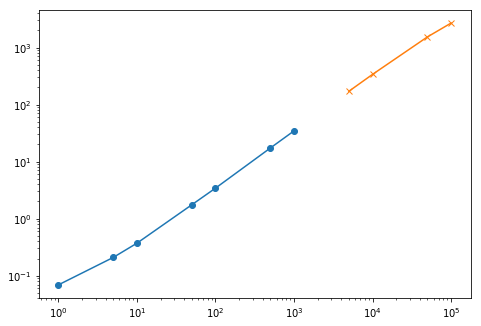

In [64]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import numpy as np

degree=2
samples=(1,    5,    10,   50,  100, 500, 1000) # Number of geoID samples 
times=(  0.069,0.209,0.371,1.75,3.42,17.3,34.5) # Time to construct multigraph
wanted = (5000,10000,50000,100000)               # Total samples

X = np.array(samples)[:,np.newaxis]
y = np.array(times)
X_pred = np.array(wanted)[:,np.newaxis]

model = make_pipeline(PolynomialFeatures(degree=2), Ridge())
model.fit(X, y)
y_pred = model.predict(X_pred)

X_particular = np.array([0,clean_tags['geo_id'].nunique()])[:,np.newaxis]
y_particular = model.predict(X_particular)
print('Estimated time for', X_particular[1] , 'samples: ', y_particular[1]/60,'[min]' )
print(model.get_params())

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.set_xscale('log')
ax.set_yscale('log')

ax = plt.plot(X, y, '-o')
ax = plt.plot(X_pred, y_pred, '-x')

plt.show()

In [9]:
# Create weighted graph
az = nx.Graph()
for u,v,data in az_MG.edges(data=True):
    w = data['weight'] if 'weight' in data else 1.0
    if az.has_edge(u,v):
        az[u][v]['weight'] += w
    else:
        az.add_edge(u, v, weight=w)

/Users/luvela/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


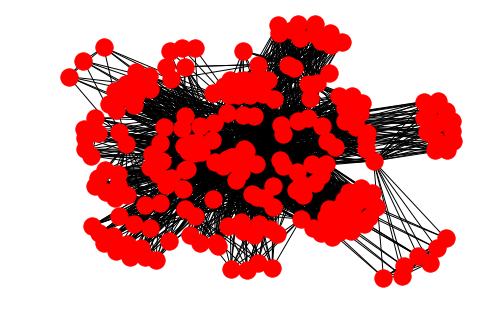

In [10]:
# Draw it
nx.draw(az)
plt.show()